In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np 
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import sys
import pdb

In [4]:
sys.path.append('../..')

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import pickle
from sklearn.model_selection import KFold
import glob
from utils import calc_loadings
from loaders import load_sabes, load_peanut
from decoders import lr_decoder, lr_encoder
from utils import apply_df_filters

In [13]:
sabes_decoding_files = glob.glob('/media/akumar/Secondary/data/cosyne_results/sabes_decoding/sabes_decoding_*.dat')
sabes_kca_files = glob.glob('/media/akumar/Secondary/data/cosyne_results/sabes_kca/sabes_kca_*.dat')
peanut_decoding_files = glob.glob('/media/akumar/Secondary/data/cosyne_results/peanut_decoding/peanut_decoding_*.dat')
peanut_kca_files = glob.glob('/media/akumar/Secondary/data/cosyne_results/peanut_kca/peanut_kca_*.dat')                            

In [14]:
results_list = []
for file in peanut_kca_files:
    with open(file, 'rb') as f:
        result_ = pickle.load(f)
    results_list.extend(result_)
peanut_kca_df = pd.DataFrame(results_list)

In [15]:
results_list = []
for file in sabes_kca_files:
    with open(file, 'rb') as f:
        result_ = pickle.load(f)
    results_list.extend(result_)
sabes_kca_df = pd.DataFrame(results_list)

### Sabes

In [67]:
data_path = '/media/akumar/Secondary/data/sabes'

In [68]:
data_files = sabes_kca_df["data_file"].unique()

In [69]:
sabes_kca_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'KCA', 'fit_all',
       'bin_width', 'filter_fn', 'filter_kwargs', 'boxcox', 'spike_threshold',
       'dim_vals', 'n_folds', 'T', 'ols_order', 'data_file', 'PCA', 'SFA'],
      dtype='object')

In [91]:
decoder_params = {'trainlag': 4, 'testlag': 4, 'decoding_window': 3}
fold_idx = 0

result = {}
for data_file in tqdm(data_files):
    
    result[data_file] = {}
    
    KCA_df = apply_df_filters(sabes_kca_df, data_file=data_file, fold_idx=fold_idx)
    pca_df = apply_df_filters(sabes_kca_df, data_file=data_file, fit_all=True, fold_idx=fold_idx)
    
    dat = load_sabes('%s/%s' % (data_path, data_file), bin_width=KCA_df.iloc[0]["bin_width"],
                     filter_fn=KCA_df.iloc[0]['filter_fn'], filter_kwargs=KCA_df.iloc[0]['filter_kwargs'],
                     boxcox=KCA_df.iloc[0]['boxcox'], spike_threshold=KCA_df.iloc[0]['spike_threshold'])
    
    X = np.squeeze(dat['spike_rates'])
    Z = dat['behavior']
    kfold = KFold(n_splits=5, shuffle=False)
    train_idxs, test_idxs = next(kfold.split(X))
    ztrain = Z[train_idxs, :]
    ztest = Z[test_idxs, :]

    # Population level decoding/encoding - use the coefficient in the linear fit
    # Record both the weights in the coefficient but also the loadings onto the SVD

    xtrain = X[train_idxs, :]
    xtest = X[test_idxs, :]
    
    _, _, _, decodingregressor = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
    _, encodingregressor = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)

    result[data_file]['decoding_weights'] = decodingregressor.coef_
    result[data_file]['encoding_weights'] = encodingregressor.coef_
    
    u1, s1, vh1 = np.linalg.svd(decodingregressor.coef_[0:2, :], full_matrices=False)
    u2, s2, vh2 = np.linalg.svd(decodingregressor.coef_[2:4, :], full_matrices=False)
    u3, s3, vh3 = np.linalg.svd(decodingregressor.coef_[4:6, :], full_matrices=False)

    
    u4, s4, vh4 = np.linalg.svd(encodingregressor.coef_, full_matrices=False)
    
    result[data_file]['decoding_pos_svd'] = vh1
    result[data_file]['decoding_vel_svd'] = vh2
    result[data_file]['decoding_acc_svd'] = vh3

    result[data_file]['encoding_svd'] = u4
    
    r2_pos_decoding, r2_vel_decoding, r2_encoding = [], [], []
    
    decoding_weights = []
    encoding_weights = []
    
    decoding_weights_svd = []
    encoding_weights_svd = []
    
    
    for neu_idx in range(X.shape[1]):           #Fit all neurons one by one
        
        xtrain = X[train_idxs, neu_idx][:, np.newaxis]
        xtest = X[test_idxs, neu_idx][:, np.newaxis]
        # Decoding
        r2_pos, r2_vel, _, dr = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        r2_pos_decoding.append(r2_pos)
        r2_vel_decoding.append(r2_vel)
        
        decoding_weights.append(dr.coef_)
        
        # Encoding
        r2_encoding_, er = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        r2_encoding.append(r2_encoding_)
        encoding_weights.append(er.coef_)        
        
    result[data_file]['su_r2_pos_decoding'] = r2_pos_decoding
    result[data_file]['su_r2_vel_decoding'] = r2_vel_decoding
    result[data_file]['su_r2_encoding'] = r2_encoding
    result[data_file]['su_decoding_weight'] = decoding_weights
    result[data_file]['su_encoding_weight'] = encoding_weights        
    
    dim_vals = np.unique(KCA_df['dim'].values)
    KCA_loadings = np.zeros((dim_vals.size, X.shape[1]))
    pca_loadings = np.zeros((dim_vals.size, X.shape[1]))
    
    for i, dim_ in enumerate(dim_vals):
        KCA_df_ = KCA_df.loc[KCA_df['dim'] == dim_]
        KCA_loadings[i, :] = calc_loadings(KCA_df_.iloc[0]['KCA']['coef'])
        pca_loadings[i, :] = calc_loadings(pca_df.iloc[0]['PCA']['coef'][:, 0:dim_])
    
    result[data_file]['kca_loadings'] = KCA_loadings
    result[data_file]['pca_loadings'] = pca_loadings

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [04:29<00:00,  9.64s/it]


In [176]:
dim_vals = np.arange(30)

In [177]:
# For each quantity, calculate the spearman r2 
dca_decoding_weightsr2 = np.zeros(dim_vals.size)
dca_decoding_svdr2 = np.zeros(dim_vals.size)
pca_decoding_weightsr2 = np.zeros(dim_vals.size)
pca_decoding_svdr2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['kca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend(calc_loadings(result[data_file]['decoding_weights'][2:4, :].T, 3))
        x2.extend(calc_loadings(result[data_file]['decoding_vel_svd'].T, 3))

    dca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    dca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_dca)[0]
    
    pca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

In [178]:
pca_decoding_weightsr2

array([0.3614911 , 0.42880271, 0.42630023, 0.42162091, 0.40789737,
       0.40236037, 0.3963059 , 0.39103937, 0.38622569, 0.3840631 ,
       0.38186928, 0.3794625 , 0.37813434, 0.37653339, 0.37458514,
       0.37284716, 0.37130482, 0.36918076, 0.36662584, 0.36423184,
       0.36213574, 0.3596151 , 0.35731322, 0.35532666, 0.3529454 ,
       0.34969866, 0.34754943, 0.34528133, 0.34351969, 0.34172005])

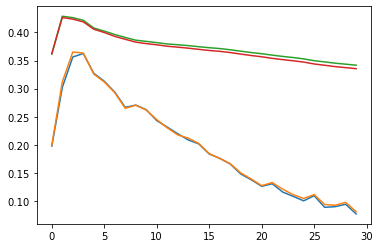

In [179]:
plt.plot(dca_decoding_weightsr2)
plt.plot(dca_decoding_svdr2)
plt.plot(pca_decoding_weightsr2)
plt.plot(pca_decoding_svdr2)

In [180]:
# For each quantity, calculate the spearman r2 
dca_encoding_weightsr2 = np.zeros(dim_vals.size)
dca_encoding_svdr2 = np.zeros(dim_vals.size)
pca_encoding_weightsr2 = np.zeros(dim_vals.size)
pca_encoding_svdr2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['kca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend(calc_loadings(result[data_file]['encoding_weights'], 1))
        x2.extend(calc_loadings(result[data_file]['encoding_svd'], 1))

    dca_encoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    dca_encoding_svdr2[i] = scipy.stats.spearmanr(x2, y_dca)[0]
    
    pca_encoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_encoding_svdr2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

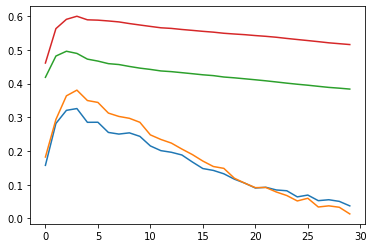

In [181]:
plt.plot(dca_encoding_weightsr2)
plt.plot(dca_encoding_svdr2)
plt.plot(pca_encoding_weightsr2)
plt.plot(pca_encoding_svdr2)

In [182]:
# For each quantity, calculate the spearman r2 
dca_suposweight_r2 = np.zeros(dim_vals.size)
dca_suvelweight_r2 = np.zeros(dim_vals.size)
pca_suposweight_r2 = np.zeros(dim_vals.size)
pca_suvelweight_r2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['kca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend([np.linalg.norm(result[data_file]['su_decoding_weight'][idx][0:2, :])
                   for idx in range(len(result[data_file]['su_decoding_weight']))])
        x2.extend([np.linalg.norm(result[data_file]['su_decoding_weight'][idx][2:4, :])
                   for idx in range(len(result[data_file]['su_decoding_weight']))])

    dca_suposweight_r2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    dca_suvelweight_r2[i] = scipy.stats.spearmanr(x2, y_dca)[0]
    
    pca_suposweight_r2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_suvelweight_r2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

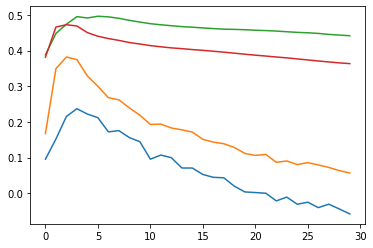

In [183]:
plt.plot(dca_suposweight_r2)
plt.plot(dca_suvelweight_r2)
plt.plot(pca_suposweight_r2)
plt.plot(pca_suvelweight_r2)

In [184]:
# For each quantity, calculate the spearman r2 
dca_suencoding_r2 = np.zeros(dim_vals.size)
pca_suencoding_r2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['kca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend([np.linalg.norm(result[data_file]['su_encoding_weight'][idx])
                   for idx in range(len(result[data_file]['su_encoding_weight']))])

    dca_suencoding_r2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    pca_suencoding_r2[i] = scipy.stats.spearmanr(x1, y_pca)[0]

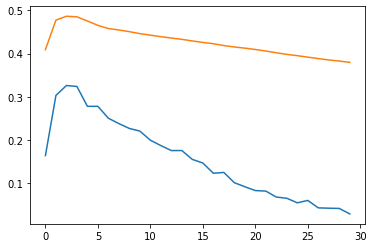

In [185]:
plt.plot(dca_suencoding_r2)
plt.plot(pca_suencoding_r2)

In [22]:
from tqdm import tqdm
from neurosim.models.ssr import StateSpaceRealization as SSR
from dca_research.kca import calc_mmse_from_cross_cov_mats
from dca.cov_util import calc_cross_cov_mats_from_data
from utils import apply_df_filters
import torch

In [19]:
with open('../v2/sabes_var_df.dat', 'rb') as f:
    var_df = pickle.load(f)

In [20]:
data_files = np.unique(var_df['data_file'].values)

In [104]:
datpath = '/media/akumar/Secondary/data/sabes'
ammse = {}
variance = {}
for i, data_file in tqdm(enumerate(data_files)):
    
    df = apply_df_filters(var_df, data_file=data_file, fold_idx=0)
    dat = load_sabes('%s/%s' % (datpath, data_file), **df.iloc[0]['loader_args'])
    x = np.squeeze(dat['spike_rates'])
    
    kfold = KFold(n_splits=5, shuffle=False)
    split_idxs = list(kfold.split(x))
    # Stick to first fold of the data
    train_idxs, test_idxs = split_idxs[0]
    
    x = x[train_idxs]

    
    A = df.iloc[0]['A']
    ssr = SSR(A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))

    variance[data_file] = {}
    variance[data_file]['data'] = np.var(x, axis=0)
    variance[data_file]['model'] = np.diag(df.iloc[0]['W'])
    
    # Do NOT Normalize
    #x = StandardScaler().fit_transform(np.squeeze(dat['spike_rates']))
    cross_cov_mats = calc_cross_cov_mats_from_data(x, T=6)
    ammse[data_file] = {}
    ammse[data_file]['dataT1'] = []
    ammse[data_file]['dataT3'] = []
    ammse[data_file]['dataT5'] = []
    ammse[data_file]['modelT1'] = []
    ammse[data_file]['modelT3'] = []
    ammse[data_file]['modelT5'] = []

    cross_cov_mats = torch.tensor(cross_cov_mats)
    for j in range(A.shape[0]):

        C = np.zeros((1, A.shape[0]))
        C[0, j] = 1

        
        ammse[data_file]['dataT5'].append(calc_mmse_from_cross_cov_mats(torch.transpose(cross_cov_mats, 1, 2), 
                                                                        torch.tensor(C.T),
                                                                        project_mmse=True).detach().cpu().numpy())                
        ammse[data_file]['dataT3'].append(calc_mmse_from_cross_cov_mats(torch.transpose(cross_cov_mats[0:4], 1, 2), 
                                                                        torch.tensor(C.T),
                                                                        project_mmse=True).detach().cpu().numpy())                
        ammse[data_file]['dataT1'].append(calc_mmse_from_cross_cov_mats(torch.transpose(cross_cov_mats[0:2], 1, 2), 
                                                                        torch.tensor(C.T),
                                                                        project_mmse=True).detach().cpu().numpy())                
    
        c, cf, cfp = ssr.acausal_mmse_cov(5, proj=C)
        ammse[data_file]['modelT5'].append(np.trace(C @ c @ C.T - C @ cfp.T @ np.linalg.inv(cf) @ cfp @ C.T))

        c, cf, cfp = ssr.acausal_mmse_cov(3, proj=C)
        ammse[data_file]['modelT3'].append(np.trace(C @ c @ C.T - C @ cfp.T @ np.linalg.inv(cf) @ cfp @ C.T))

        c, cf, cfp = ssr.acausal_mmse_cov(1, proj=C)
        ammse[data_file]['modelT1'].append(np.trace(C @ c @ C.T - C @ cfp.T @ np.linalg.inv(cf) @ cfp @ C.T))

28it [04:09,  8.92s/it]


In [189]:
# (empirical su variance)
x1 = []
# (model su variance)
x2 =[]
# (emprirical T1)
x3 = []
# (emprirical T3)
x4 = []
# (emprirical T5)
x5 = []
# (model T1)
x6 = []
# (model T3)
x7 = []
# (model T5)
x8 = []

# pca loadings
y1 = []
# kca loadings 
y2 = []

fold_idx = 0
for i, data_file in enumerate(data_files):

    KCA_df = apply_df_filters(sabes_kca_df, data_file=data_file, fold_idx=fold_idx, dim=2)
    pca_df = apply_df_filters(sabes_kca_df, data_file=data_file, fit_all=True, fold_idx=fold_idx)
    
    x1.extend(variance[data_file]['data'])
    x2.extend(variance[data_file]['model'])

    x3.extend(ammse[data_file]['dataT1'])
    x4.extend(ammse[data_file]['dataT3'])
    x5.extend(ammse[data_file]['dataT5'])
    
    x6.extend(ammse[data_file]['modelT1'])
    x7.extend(ammse[data_file]['modelT3'])
    x8.extend(ammse[data_file]['modelT5'])
    
    y1.extend(calc_loadings(pca_df.iloc[0]['PCA']['coef'][:, 0:2]))
    y2.extend(calc_loadings(KCA_df.iloc[0]['KCA']['coef'])) 

    
r = np.zeros((8, 2))
for i, x_ in enumerate([x1, x2, x3, x4, x5, x6, x7, x8]):
    for j, y_ in enumerate([y1, y2]):
        r[i, j] = scipy.stats.spearmanr(x_, y_)[0]    

In [70]:
from dca_research.kca import KalmanComponentsAnalysis as KCA

In [71]:
from sklearn.decomposition import PCA

In [123]:
# Evaluate self consistency with model subspaces
reps = 10

spearmanr_kca = []

for i, data_file in tqdm(enumerate(data_files)):
    
    df = apply_df_filters(var_df, data_file=data_file, fold_idx=0)
    dat = load_sabes('%s/%s' % (datpath, data_file), **df.iloc[0]['loader_args'])
    x = np.squeeze(dat['spike_rates'])
    
    kfold = KFold(n_splits=5, shuffle=False)
    split_idxs = list(kfold.split(x))
    # Stick to first fold of the data
    train_idxs, test_idxs = split_idxs[0]
    
    x = x[train_idxs]

    
    A = df.iloc[0]['A']
    ssr = SSR(A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))

    eig, U = np.linalg.eig(ssr.P)
    eigorder = np.argsort(eig)
    U = U[:, eigorder]
        
    # Data derived
    
    kcamodel = KCA(d=2, T=1, causal_weights=(0, 1), project_mmse=True)
    kcamodel.estimate_data_statistics(x)

    empirical_loadings = np.zeros((reps, A.shape[0]))
    for j in range(reps):
        coef_, _ = kcamodel._fit_projection()
        empirical_loadings[j, :] = calc_loadings(coef_)
    
    # Model derived
    model_loadings = np.zeros((reps, A.shape[0]))
    kcamodel = KCA(d=2, T=1, causal_weights=(0, 1), project_mmse=True)
    kcamodel.cross_covs = ssr.autocorrelation(5)
    for j in range(reps):
        coef_, _ = kcamodel._fit_projection()
        model_loadings[j, :] = calc_loadings(coef_)
        
    sr = np.zeros((reps, reps))
    for j in range(reps):
        for k in range(reps):
            sr[j, k] = scipy.stats.spearmanr(empirical_loadings[j, :], model_loadings[k, :])[0]
    spearmanr_kca.append(sr)

28it [03:57,  8.50s/it]


In [1]:
# Question 1: Do the backwards models lead to the same autocorrelation of y?

In [58]:
df = apply_df_filters(var_df, data_file=data_files[0], fold_idx=0)
A = df.iloc[0]['A']
forward_ssr = SSR(A=A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))
forward_ssr.solve_reverse_system2()
reversed_ssr = SSR(A=A.T, B=forward_ssr.Br, C=forward_ssr.Cr, D=forward_ssr.Dr)

In [60]:
ccm1 = forward_ssr.autocorrelation(10)
ccm2 = reversed_ssr.autocorrelation(10)

In [62]:
ccm1[1]

array([[ 9.67467474e-02, -3.38732332e-02, -2.06589217e-02, ...,
         2.05337203e-02,  2.16404957e-02,  1.60765246e-02],
       [-5.02482550e-03,  1.58830002e-03, -1.28847018e-02, ...,
         1.04198233e-03,  7.75034878e-03,  1.53275664e-02],
       [-1.58022291e-02, -1.94967360e-02,  4.39269441e-03, ...,
        -8.09573349e-04,  1.95116932e-03,  2.01707337e-03],
       ...,
       [ 4.40868018e-02,  8.02092977e-04,  4.04342091e-05, ...,
         1.15733519e-02,  6.71215821e-03,  2.22819192e-02],
       [ 3.82905412e-02,  5.78365724e-04,  2.05268143e-03, ...,
         6.52009032e-03,  9.01743976e-03,  6.18065818e-03],
       [ 1.66444230e-02,  5.13696108e-04,  1.47368096e-03, ...,
         9.09990882e-03,  5.45543983e-03,  6.02429770e-03]])

In [65]:
np.allclose(np.linalg.inv(forward_ssr.P

array([[ 8.96118236e-01, -1.24178723e-03,  2.42689189e-03, ...,
        -1.52871397e-02, -9.40989072e-03, -4.41781050e-03],
       [-1.24178723e-03,  9.86631379e-01,  6.79142130e-04, ...,
        -5.68443753e-03, -2.96889589e-03, -4.03013272e-04],
       [ 2.42689189e-03,  6.79142130e-04,  9.77529044e-01, ...,
         2.55450188e-03, -1.73438727e-03, -1.48155717e-03],
       ...,
       [-1.52871397e-02, -5.68443753e-03,  2.55450188e-03, ...,
         9.71965045e-01, -1.25922293e-03, -3.16054401e-03],
       [-9.40989072e-03, -2.96889589e-03, -1.73438727e-03, ...,
        -1.25922293e-03,  9.81934964e-01, -1.11081870e-03],
       [-4.41781050e-03, -4.03013272e-04, -1.48155717e-03, ...,
        -3.16054401e-03, -1.11081870e-03,  9.92103229e-01]])

In [64]:
reversed_ssr.P

array([[ 8.51911590e-01, -5.69824185e-03, -4.88816471e-03, ...,
        -2.29248722e-02, -8.98847848e-03, -5.87527952e-03],
       [-5.69824185e-03,  1.00590673e+00,  1.42191614e-03, ...,
        -1.04415083e-02, -2.12137999e-03, -6.20518923e-04],
       [-4.88816471e-03,  1.42191614e-03,  9.94634296e-01, ...,
         1.44815215e-03, -4.42344456e-03, -6.57670652e-04],
       ...,
       [-2.29248722e-02, -1.04415083e-02,  1.44815215e-03, ...,
         9.55723112e-01, -1.58939173e-03, -3.40541265e-03],
       [-8.98847848e-03, -2.12137999e-03, -4.42344456e-03, ...,
        -1.58939173e-03,  9.79804613e-01, -1.27209959e-03],
       [-5.87527952e-03, -6.20518923e-04, -6.57670652e-04, ...,
        -3.40541265e-03, -1.27209959e-03,  1.00119524e+00]])

In [63]:
ccm2[1]

array([[ 5.54141820e-02, -8.00472848e-03, -1.72706557e-02, ...,
         3.23657071e-02,  3.07012510e-02,  9.57740920e-03],
       [-2.47654659e-02,  1.61865308e-03, -1.76783017e-02, ...,
         3.06944364e-03,  3.36441552e-04,  1.46539927e-03],
       [-1.90838845e-02, -1.38821628e-02,  4.27126060e-03, ...,
         2.38558874e-03,  1.12455642e-03,  1.63582837e-03],
       ...,
       [ 1.31272633e-02, -7.61604234e-05, -3.63315960e-04, ...,
         5.94661426e-03,  3.47255035e-03,  6.71642189e-03],
       [ 1.21749289e-02,  6.70203855e-03,  1.49898397e-03, ...,
         4.72489434e-03,  5.18491226e-03,  2.83030673e-03],
       [ 8.82090243e-03,  1.54077888e-02,  1.55785856e-03, ...,
         1.62584048e-02,  4.42565545e-03,  3.78077312e-03]])

In [76]:
# Evaluate self consistency with model subspaces when the noises are decorrelated
reps = 10

spearmanr_kca = []
subspace_angles = np.zeros((len(data_files), reps, reps, 2))
subspace_angles_pca = np.zeros((len(data_files, reps, reps, 2)))
for i, data_file in tqdm(enumerate(data_files)):
    
    df = apply_df_filters(var_df, data_file=data_file, fold_idx=0)
    dat = load_sabes('%s/%s' % (data_path, data_file), **df.iloc[0]['loader_args'])
    x = np.squeeze(dat['spike_rates'])
    
    kfold = KFold(n_splits=5, shuffle=False)
    split_idxs = list(kfold.split(x))
    # Stick to first fold of the data
    train_idxs, test_idxs = split_idxs[0]
    
    x = x[train_idxs]

    
    A = df.iloc[0]['A']
    forward_ssr = SSR(A=A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))
    forward_ssr.solve_reverse_system()
    reversed_ssr = SSR(A=A.T, B=forward_ssr.Bbar, C=forward_ssr.Cbar, D=forward_ssr.Dbar)
    
#     eig, U = np.linalg.eig(ssr.P)
#     eigorder = np.argsort(eig)
#     U = U[:, eigorder]
        
    # Data derived
    
    kcamodel = KCA(d=2, T=1, causal_weights=(0, 1), project_mmse=True)
    kcamodel.estimate_data_statistics(x)

    empirical_loadings = np.zeros((reps, A.shape[0]))
    empirical_coefs = []
    for j in range(reps):
        coef_, _ = kcamodel._fit_projection()
        empirical_loadings[j, :] = calc_loadings(coef_)
        empirical_coefs.append(coef_)
        
    # Model derived - forward time filtering on the reversed_ssr autocorrelation
    model_loadings = np.zeros((reps, A.shape[0]))
    kcamodel = KCA(d=2, T=1, causal_weights=(1, 0), project_mmse=True)
    kcamodel.cross_covs = reversed_ssr.autocorrelation(5)
    model_coefs = []
    for j in range(reps):
        coef_, _ = kcamodel._fit_projection()
        model_loadings[j, :] = calc_loadings(coef_)
        model_coefs.append(coef_)
        
    sr = np.zeros((reps, reps))
    for j in range(reps):
        for k in range(reps):
            subspace_angles[i, j, k, :] = scipy.linalg.subspace_angles(empirical_coefs[j], model_coefs[k])
            sr[j, k] = scipy.stats.spearmanr(empirical_loadings[j, :], model_loadings[k, :])[0]
    spearmanr_kca.append(sr)

0it [00:00, ?it/s]

Warning, this solution may not be consistent with decorrelated observational and process noise


1it [00:17, 17.65s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


2it [00:41, 21.45s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


3it [00:47, 14.24s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


4it [01:19, 21.26s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


5it [01:33, 18.83s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


6it [01:38, 14.03s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


7it [01:43, 10.89s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


8it [01:48,  9.16s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


9it [01:53,  7.85s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


10it [01:57,  6.79s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


11it [02:03,  6.54s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


12it [02:09,  6.23s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


13it [02:16,  6.56s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


14it [02:22,  6.36s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


15it [02:28,  6.22s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


16it [02:34,  6.06s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


17it [02:39,  5.88s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


18it [02:45,  5.81s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


19it [02:51,  5.78s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


20it [02:57,  5.98s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


21it [03:05,  6.55s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


22it [03:10,  6.17s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


23it [03:17,  6.23s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


24it [03:23,  6.27s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


25it [03:30,  6.46s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


26it [03:36,  6.50s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


27it [03:44,  6.92s/it]

Warning, this solution may not be consistent with decorrelated observational and process noise


28it [03:53,  8.35s/it]


In [97]:
np.min(np.sum(subspace_angles[20], axis=-1))

0.7255482861290787

In [192]:
loadingsW = []
loadingsPCA = []
for i, data_file in enumerate(data_files):

#     # OLS
#     df_ = apply_df_filters(dimreduc_df, dimreduc='OLS1', data_file=data_file, fold_idx=0)
#     A = np.squeeze(df_.iloc[0]['coef'])
#     W = scipy.linalg.solve_discrete_lyapunov(A, np.eye(A.shape[0]))    
#     eig, U = np.linalg.eig(W)
#     eigorder = np.argsort(np.abs(eig))[::-1]
#     U = U[:, eigorder]
#     loadingsW.extend(calc_loadings(U[:, 0:2], 1))
    
    # SCAD
    df_ = apply_df_filters(var_df, fold_idx=0, data_file=data_file)
    
    W = df_.iloc[0]['W']
    eig, U = np.linalg.eig(W)
    eigorder = np.argsort(np.abs(eig))[::-1]
    U = U[:, eigorder]
    loadingsW.extend(calc_loadings(U[:, 0:2], 1))

    # PCA
    df_ = apply_df_filters(sabes_kca_df, fit_all=True, data_file=data_file, fold_idx=0)
    V = df_.iloc[0]['PCA']['coef'][:, 0:2]
    loadingsPCA.extend(calc_loadings(V, 1))


In [193]:
spearmanr_pca = scipy.stats.spearmanr(loadingsW, loadingsPCA)[0]

In [194]:
np.mean([np.max(r) for r in spearmanr_kca])

0.8902342221403486

In [134]:
# # Save
# with open('sabes_su_correlations.dat', 'wb') as f:
#     f.write(pickle.dumps(result))
#     f.write(pickle.dumps(variance))
#     f.write(pickle.dumps(ammse))
#     # This is model self consistency
#     f.write(pickle.dumps(spearmanr_kca))

In [172]:
# Save
with open('sabes_su_correlations.dat', 'rb') as f:
    result = pickle.load(f)
    variance = pickle.load(f)
    ammse = pickle.load(f)
    spearmanr_kca = pickle.load(f)

In [137]:
r[:, 1]

array([-0.0984717 ,  0.10648992, -0.11241712, -0.11775665, -0.11814682,
        0.10601915,  0.10124447,  0.10088619])

In [195]:
# Load the single neuron tuning results
with open('sabes_tuning_correlation.dat', 'rb') as f:
    cor_bins_coef_kca = pickle.load(f)
    cor_bins_coef_pca = pickle.load(f)

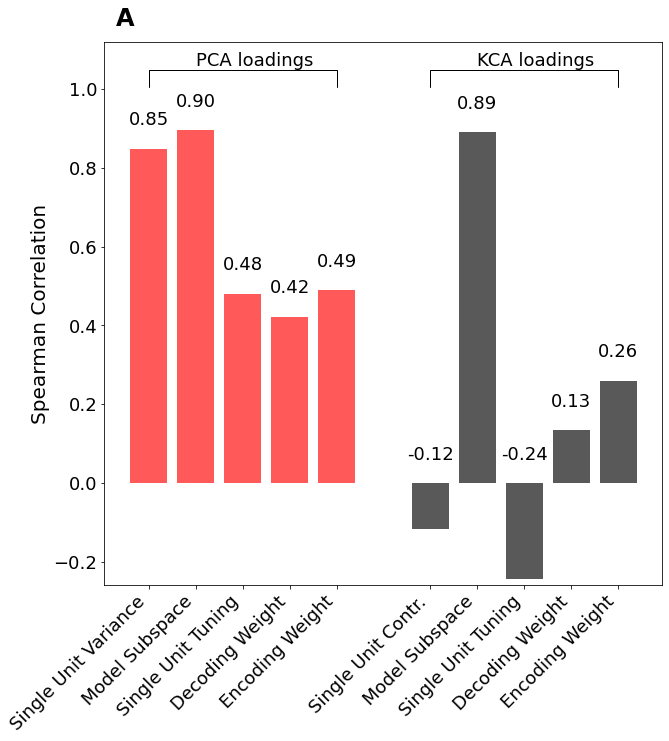

In [220]:
fig, ax = plt.subplots(figsize=(10, 10), )

bars = ax.bar([0, 1, 2, 3, 4, 6, 7, 8, 9, 10], [r[0, 0], spearmanr_pca, np.mean(cor_bins_coef_pca[1]),
                                         pca_decoding_weightsr2[3], pca_encoding_weightsr2[3],
                                         r[3, 1], np.mean([np.max(r) for r in spearmanr_kca]),
                                         np.mean(cor_bins_coef_kca[1]), kca_decoding_weightsr2[3],
                                         kca_encoding_weightsr2[3]],
              color=['r', 'r', 'r', 'r', 'r', 'k', 'k', 'k', 'k', 'k'], alpha=0.65)

# Place numerical values above the bars
for rect in bars: 
    if rect.get_height() > 0:
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.05, '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=18)
    else:
        ax.text(rect.get_x() + rect.get_width()/2, 0.05, '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=18)
        
ax.set_ylim([-0.26, 1.12])
ax.set_xticks([0, 1, 2, 3, 4, 6, 7, 8, 9, 10])
ax.set_xticklabels(['Single Unit Variance', 'Model Subspace', 'Single Unit Tuning',
                    'Decoding Weight', 'Encoding Weight',
                    'Single Unit Contr.', 'Model Subspace', 'Single Unit Tuning',
                    'Decoding Weight', 'Encoding Weight'],
                   rotation=45, fontsize=18, ha='right')
ax.tick_params(axis='y', labelsize=18)
ax.text(1, 1.05, 'PCA loadings', fontsize=18, ha='left', va='bottom')


ax.annotate("", xy=(0, 1.0), xytext=(4, 1.0), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))

ax.text(7, 1.05, 'KCA loadings', fontsize=18, ha='left', va='bottom')
ax.annotate("", xy=(6, 1.0), xytext=(10, 1.0), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))

ax.set_ylabel('Spearman Correlation', fontsize=20)
ax.text(0.02, 1.02, 'A', transform=ax.transAxes,
        fontsize=24, fontweight='bold', va='bottom')    

fig.savefig('sabes_loadings_correlation.pdf', bbox_inches='tight', pad_inches=0)

### Peanut

In [221]:
fpath = '/media/akumar/Secondary/data/peanut/data_dict_peanut_day14.obj'

In [222]:
epochs = np.unique(peanut_kca_df['epoch'].values)

In [228]:
decoder_params = {'trainlag': 0, 'testlag': 0, 'decoding_window': 6}
fold_idx = 1

result = {}
for epoch in tqdm(epochs):
    
    result[epoch] = {}
    
    KCA_df = apply_df_filters(peanut_kca_df, epoch=epoch, fold_idx=fold_idx)
    pca_df = apply_df_filters(peanut_kca_df, epoch=epoch, fit_all=True, fold_idx=fold_idx)
    
    dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=KCA_df.iloc[0]['bin_width'], 
                      filter_fn='none')
    
    
    X = np.squeeze(dat['spike_rates'])
    Z = dat['behavior']
    kfold = KFold(n_splits=5, shuffle=False)
    next(kfold.split(X))
    train_idxs, test_idxs = next(kfold.split(X))
    ztrain = Z[train_idxs, :]
    ztest = Z[test_idxs, :]

    # Population level decoding/encoding - use the coefficient in the linear fit
    # Record both the weights in the coefficient but also the loadings onto the SVD

    xtrain = X[train_idxs, :]
    xtest = X[test_idxs, :]
    
    _, _, _, decodingregressor = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
    _, encodingregressor = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)


    result[epoch]['decoding_weights'] = decodingregressor.coef_
    result[epoch]['encoding_weights'] = encodingregressor.coef_
    
    u1, s1, vh1 = np.linalg.svd(decodingregressor.coef_[0:1, :], full_matrices=False)
    u4, s4, vh4 = np.linalg.svd(encodingregressor.coef_, full_matrices=False)
    
    result[epoch]['decoding_pos_svd'] = vh1
    result[epoch]['encoding_svd'] = u4
    
    r2_pos_decoding = []
    r2_encoding = []
    
    decoding_weights = []
    encoding_weights = []
    
    decoding_weights_svd = []
    encoding_weights_svd = []
    
    
    for neu_idx in range(X.shape[1]):           #Fit all neurons one by one
        
        xtrain = X[train_idxs, neu_idx][:, np.newaxis]
        xtest = X[test_idxs, neu_idx][:, np.newaxis]
        # Decoding
        r2_pos, _, _, dr = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        r2_pos_decoding.append(r2_pos)        
        decoding_weights.append(dr.coef_)
        
        # Encoding
        r2_encoding_, er = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        r2_encoding.append(r2_encoding_)
        encoding_weights.append(er.coef_)        
        
    result[epoch]['su_r2_pos_decoding'] = r2_pos_decoding
    result[epoch]['su_r2_encoding'] = r2_encoding
    result[epoch]['su_decoding_weight'] = decoding_weights
    result[epoch]['su_encoding_weight'] = encoding_weights        
    
    dim_vals = np.unique(KCA_df['dim'].values)
    kca_loadings = np.zeros((dim_vals.size, X.shape[1]))
    pca_loadings = np.zeros((dim_vals.size, X.shape[1]))
    
    for i, dim_ in enumerate(dim_vals):
        kca_df_ = KCA_df.loc[KCA_df['dim'] == dim_]
        kca_loadings[i, :] = calc_loadings(kca_df_.iloc[0]['KCA']['coef'])
        pca_loadings[i, :] = calc_loadings(pca_df.iloc[0]['PCA']['coef'][:, 0:dim_])
    
    result[epoch]['kca_loadings'] = kca_loadings
    result[epoch]['pca_loadings'] = pca_loadings

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.29s/it]


In [229]:
# For each quantity, calculate the spearman r2 
kca_decoding_weightsr2 = np.zeros(dim_vals.size)
kca_decoding_svdr2 = np.zeros(dim_vals.size)
pca_decoding_weightsr2 = np.zeros(dim_vals.size)
pca_decoding_svdr2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_kca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for epoch in epochs:
        y_kca.extend(result[epoch]['kca_loadings'][i, :])
        y_pca.extend(result[epoch]['pca_loadings'][i, :])
        
        x1.extend(calc_loadings(result[epoch]['decoding_weights'][0, :][np.newaxis, :].T, 6))
        x2.extend(calc_loadings(result[epoch]['decoding_pos_svd'].T, 6))

    kca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_kca)[0]
    kca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_kca)[0]
    
    pca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

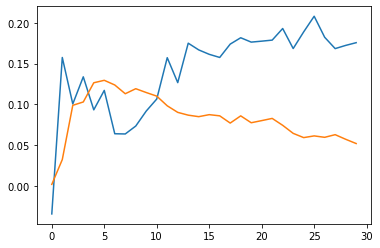

In [230]:
plt.plot(kca_decoding_weightsr2)
plt.plot(pca_decoding_weightsr2)

In [231]:
# For each quantity, calculate the spearman r2 
kca_encoding_weightsr2 = np.zeros(dim_vals.size)
kca_encoding_svdr2 = np.zeros(dim_vals.size)
pca_encoding_weightsr2 = np.zeros(dim_vals.size)
pca_encoding_svdr2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_kca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for epoch in epochs:
        y_kca.extend(result[epoch]['kca_loadings'][i, :])
        y_pca.extend(result[epoch]['pca_loadings'][i, :])
        
        x1.extend(calc_loadings(result[epoch]['encoding_weights'], 1))
        x2.extend(calc_loadings(result[epoch]['encoding_svd'], 1))
    
    kca_encoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_kca)[0]
    kca_encoding_svdr2[i] = scipy.stats.spearmanr(x2, y_kca)[0]
    
    pca_encoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_encoding_svdr2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

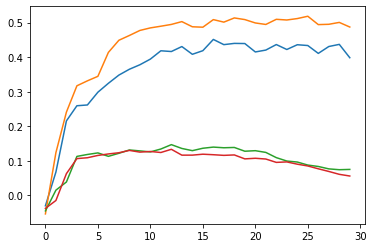

In [232]:
plt.plot(kca_encoding_weightsr2)
plt.plot(kca_encoding_svdr2)
plt.plot(pca_encoding_weightsr2)
plt.plot(pca_encoding_svdr2)

In [233]:
var_files = glob.glob('/media/akumar/Secondary/data/peanut_var2/peanut_var2_*.dat')
results_list = []
for var_file in var_files:
    result = {}
    with open(var_file, 'rb') as f:
        args = pickle.load(f)
        coefs = pickle.load(f)
        scores_and_supports = pickle.load(f)

    for key, value in args.items():
        if type(value) == dict:
            for key_, value_ in args[key].items():
                result[key_] = value_
        else:
            result[key] = value

    result['A'] = np.squeeze(coefs)
    results_list.append(result)
peanut_var_df = pd.DataFrame(results_list)

In [234]:
ammse = {}
variance = {}
for epoch in tqdm(epochs):
    # VAR is fit to fold idx 1 only
    df = apply_df_filters(peanut_var_df, epoch=epoch)
    dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=KCA_df.iloc[0]['bin_width'], 
                      filter_fn='none')

    x = np.squeeze(dat['spike_rates'])

    kfold = KFold(n_splits=5, shuffle=False)
    split_idxs = list(kfold.split(x))
    train_idxs, test_idxs = split_idxs[1]
    
    x = x[train_idxs]
    
    A = df.iloc[0]['A']
    ssr = SSR(A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))

    variance[epoch] = {}
    variance[epoch]['data'] = np.var(x, axis=0)
    W = scipy.linalg.solve_discrete_lyapunov(A, np.eye(A.shape[0]))
    variance[epoch]['model'] = np.diag(W)
    
    # Do NOT Normalize
    #x = StandardScaler().fit_transform(np.squeeze(dat['spike_rates']))
    cross_cov_mats = calc_cross_cov_mats_from_data(x, T=6)
    ammse[epoch] = {}
    ammse[epoch]['dataT1'] = []
    ammse[epoch]['dataT3'] = []
    ammse[epoch]['dataT5'] = []
    ammse[epoch]['modelT1'] = []
    ammse[epoch]['modelT3'] = []
    ammse[epoch]['modelT5'] = []

    cross_cov_mats = torch.tensor(cross_cov_mats)
    for j in range(A.shape[0]):

        C = np.zeros((1, A.shape[0]))
        C[0, j] = 1

        
        ammse[epoch]['dataT5'].append(calc_mmse_from_cross_cov_mats(torch.transpose(cross_cov_mats, 1, 2), 
                                                                        torch.tensor(C.T),
                                                                        project_mmse=True).detach().cpu().numpy())                
        ammse[epoch]['dataT3'].append(calc_mmse_from_cross_cov_mats(torch.transpose(cross_cov_mats[0:4], 1, 2), 
                                                                        torch.tensor(C.T),
                                                                        project_mmse=True).detach().cpu().numpy())                
        ammse[epoch]['dataT1'].append(calc_mmse_from_cross_cov_mats(torch.transpose(cross_cov_mats[0:2], 1, 2), 
                                                                        torch.tensor(C.T),
                                                                        project_mmse=True).detach().cpu().numpy())                
    
        c, cf, cfp = ssr.acausal_mmse_cov(5, proj=C)
        ammse[epoch]['modelT5'].append(np.trace(C @ c @ C.T - C @ cfp.T @ np.linalg.inv(cf) @ cfp @ C.T))

        c, cf, cfp = ssr.acausal_mmse_cov(3, proj=C)
        ammse[epoch]['modelT3'].append(np.trace(C @ c @ C.T - C @ cfp.T @ np.linalg.inv(cf) @ cfp @ C.T))

        c, cf, cfp = ssr.acausal_mmse_cov(1, proj=C)
        ammse[epoch]['modelT1'].append(np.trace(C @ c @ C.T - C @ cfp.T @ np.linalg.inv(cf) @ cfp @ C.T))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.90s/it]


In [235]:
# (empirical su variance)
x1 = []
# (model su variance)
x2 =[]
# (emprirical T1)
x3 = []
# (emprirical T3)
x4 = []
# (emprirical T5)
x5 = []
# (model T1)
x6 = []
# (model T3)
x7 = []
# (model T5)
x8 = []

# pca loadings
y1 = []
# kca loadings 
y2 = []

fold_idx = 1
for epoch in tqdm(epochs):
    KCA_df = apply_df_filters(peanut_kca_df, epoch=epoch, fold_idx=fold_idx, dim=2)
    pca_df = apply_df_filters(peanut_kca_df, epoch=epoch, fit_all=True, fold_idx=fold_idx)
    
    x1.extend(variance[epoch]['data'])
    x2.extend(variance[epoch]['model'])

    x3.extend(ammse[epoch]['dataT1'])
    x4.extend(ammse[epoch]['dataT3'])
    x5.extend(ammse[epoch]['dataT5'])
    
    x6.extend(ammse[epoch]['modelT1'])
    x7.extend(ammse[epoch]['modelT3'])
    x8.extend(ammse[epoch]['modelT5'])
    
    y1.extend(calc_loadings(pca_df.iloc[0]['PCA']['coef'][:, 0:2]))
    y2.extend(calc_loadings(KCA_df.iloc[0]['KCA']['coef'])) 

    
r = np.zeros((8, 2))
for i, x_ in enumerate([x1, x2, x3, x4, x5, x6, x7, x8]):
    for j, y_ in enumerate([y1, y2]):
        r[i, j] = scipy.stats.spearmanr(x_, y_)[0]    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 687.15it/s]


In [236]:
r[:, 0]

array([0.92157281, 0.76653942, 0.9236526 , 0.92190389, 0.91526933,
       0.76652193, 0.77134888, 0.77130514])

In [237]:
r[:, 1]

array([ 0.06246051,  0.158818  ,  0.0482901 ,  0.03364466, -0.000782  ,
        0.1581778 ,  0.15204581,  0.15198654])

In [238]:
# Evaluate self consistency with model subspaces
reps = 10

spearmanr_kca = []

for i, epoch in tqdm(enumerate(epochs)):
    
    # Fold idx is 1 here
    df = apply_df_filters(peanut_var_df, epoch=epoch)
    dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=KCA_df.iloc[0]['bin_width'], 
                      filter_fn='none')
    x = np.squeeze(dat['spike_rates'])
    
    kfold = KFold(n_splits=5, shuffle=False)
    split_idxs = list(kfold.split(x))
    # Stick to the correct fold of the data
    train_idxs, test_idxs = split_idxs[1]
    
    x = x[train_idxs]

    
    A = df.iloc[0]['A']
    ssr = SSR(A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))

    eig, U = np.linalg.eig(ssr.P)
    eigorder = np.argsort(eig)
    U = U[:, eigorder]
        
    # Data derived
    
    kcamodel = KCA(d=2, T=1, causal_weights=(0, 1), project_mmse=True)
    kcamodel.estimate_data_statistics(x)

    empirical_loadings = np.zeros((reps, A.shape[0]))
    for j in range(reps):
        coef_, _ = kcamodel._fit_projection()
        empirical_loadings[j, :] = calc_loadings(coef_)
    
    # Model derived
    model_loadings = np.zeros((reps, A.shape[0]))
    kcamodel = KCA(d=2, T=1, causal_weights=(0, 1), project_mmse=True)
    kcamodel.cross_covs = ssr.autocorrelation(5)
    for j in range(reps):
        coef_, _ = kcamodel._fit_projection()
        model_loadings[j, :] = calc_loadings(coef_)
        
    sr = np.zeros((reps, reps))
    for j in range(reps):
        for k in range(reps):
            sr[j, k] = scipy.stats.spearmanr(empirical_loadings[j, :], model_loadings[k, :])[0]
    spearmanr_kca.append(sr)

8it [00:38,  4.77s/it]


In [239]:
[np.max(sr) for sr in spearmanr_kca]

[0.7450733752620544,
 0.6436100131752306,
 0.7425249169435215,
 0.6778745363651023,
 0.8056765037897112,
 0.4019512981777133,
 0.8507177033492823,
 0.7464411557434812]

In [240]:
loadingsW = []
loadingsPCA = []
for i, epoch in enumerate(epochs):

#     # OLS
#     df_ = apply_df_filters(dimreduc_df, dimreduc='OLS1', epoch=epoch, fold_idx=0)
#     A = np.squeeze(df_.iloc[0]['coef'])
#     W = scipy.linalg.solve_discrete_lyapunov(A, np.eye(A.shape[0]))    
#     eig, U = np.linalg.eig(W)
#     eigorder = np.argsort(np.abs(eig))[::-1]
#     U = U[:, eigorder]
#     loadingsW.extend(calc_loadings(U[:, 0:2], 1))
    
    # SCAD
    df_ = apply_df_filters(peanut_var_df, epoch=epoch)
    W = scipy.linalg.solve_discrete_lyapunov(df_.iloc[0]['A'], np.eye(df_.iloc[0]['A'].shape[0]))
    eig, U = np.linalg.eig(W)
    eigorder = np.argsort(np.abs(eig))[::-1]
    U = U[:, eigorder]
    loadingsW.extend(calc_loadings(U[:, 0:2], 1))

    # PCA
    df_ = apply_df_filters(peanut_kca_df, fit_all=True, epoch=epoch, fold_idx=1)
    V = df_.iloc[0]['PCA']['coef'][:, 0:2]
    loadingsPCA.extend(calc_loadings(V, 1))

In [241]:
spearmanr_pca = scipy.stats.spearmanr(loadingsW, loadingsPCA)[0]

In [242]:
spearmanr_pca

0.7850835548273537

In [243]:
# # Save
with open('peanut_su_correlations.dat', 'wb') as f:
    f.write(pickle.dumps(result))
    f.write(pickle.dumps(variance))
    f.write(pickle.dumps(ammse))
    # This is model self consistency
    f.write(pickle.dumps(spearmanr_kca))

In [223]:
# with open('peanut_su_correlations.dat', 'rb') as f:
#     result = pickle.load(f)
#     variance = pickle.load(f)
#     ammse = pickle.load(f)
#     spearmanr_kca = pickle.load(f)

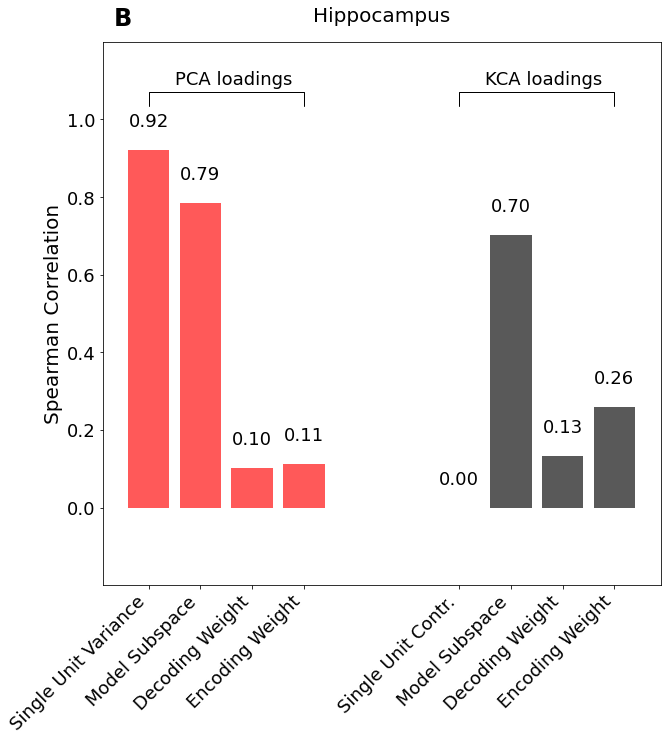

In [263]:
fig, ax = plt.subplots(figsize=(10, 10), )

bars = ax.bar([0, 1, 2, 3, 6, 7, 8, 9], [r[0, 0], spearmanr_pca, 
                                         pca_decoding_weightsr2[3], pca_encoding_weightsr2[3],
                                         r[4, 1], np.mean([np.max(r) for r in spearmanr_kca]),
                                         kca_decoding_weightsr2[3],
                                         kca_encoding_weightsr2[3]],
              color=['r', 'r', 'r', 'r', 'k', 'k', 'k', 'k'], alpha=0.65)

# Place numerical values above the bars
for rect in bars: 
    if rect.get_height() > 0:
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.05, '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=18)
    else:
        ax.text(rect.get_x() + rect.get_width()/2, 0.05, '%.2f' % np.abs(rect.get_height()),
                ha='center', va='bottom', fontsize=18)
    
ax.set_ylim([-0.2, 1.2])
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks([0, 1, 2, 3, 6, 7, 8, 9])
ax.set_xticklabels(['Single Unit Variance', 'Model Subspace',
                    'Decoding Weight', 'Encoding Weight',
                    'Single Unit Contr.', 'Model Subspace', 
                    'Decoding Weight', 'Encoding Weight'],
                   rotation=45, fontsize=18, ha='right')
ax.tick_params(axis='y', labelsize=18)
ax.text(0.5, 1.08, 'PCA loadings', fontsize=18, ha='left', va='bottom')
ax.annotate("", xy=(0, 1.03), xytext=(3, 1.03), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))


ax.text(6.5, 1.08, 'KCA loadings', fontsize=18, ha='left', va='bottom')
ax.annotate("", xy=(6, 1.03), xytext=(9, 1.03), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))

ax.set_ylabel('Spearman Correlation', fontsize=20)
ax.text(0.02, 1.02, 'B', transform=ax.transAxes,
        fontsize=24, fontweight='bold', va='bottom')    
ax.set_title('Hippocampus', fontsize=20, pad=20)
fig.savefig('peanut_loadings_correlation.pdf', bbox_inches='tight', pad_inches=0)
#fig.savefig('hwni/loadings_correlation.pdf', bbox_inches='tight', pad_inches=0)